In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

## Grab SCAM data

In [161]:
#dateSel = '20170716'

saveDir = '/project/amp/mdfowler/CLASP/processedData_ensByDay/'

hmg_day2_upsample = pickle.load( open( saveDir+"realSfc_HMG_day2_30min_pert00.p" , "rb") )
htg_day2_upsample = pickle.load( open( saveDir+"realSfc_HTG_day2_30min_pert00.p" , "rb") )

## Select day
selDay = np.where( (hmg_day2_upsample['time.year']==2017) & 
                   (hmg_day2_upsample['time.month']==7) & 
                   (hmg_day2_upsample['time.day']==16))[0]
hmg_day2_upsample = hmg_day2_upsample.isel(time=selDay)
htg_day2_upsample = htg_day2_upsample.isel(time=selDay)


## Grab LES data

**From Jason:**<br>
Files ending in _00.nc are heterogeneous cases, _01.nc are homogeneous.

These come with two caveats.  First, I made these just merging netCDF output files as they exist in the run directories.  Due to sloppy job management on my end, a lot of these jobs output a few timesteps before running out of allocation and were then restarted at a time before that final output.  Point being, there's some duplicate time entries that I didn't trim out, so you'll have to pay a little attention to the timestamps.

Second, I made these by hand so it's not impossible that one or more of these is missing a chunk of output, so again you'll have to pay a little attention to the timestamps.  If you find any gaps let me know and I'll fill them.

In [140]:
lesDir = '/project/amp/mdfowler/CLASP/LESdata_fromJason/'

dateSel = '20170716'

HTGds = xr.open_dataset(lesDir+'megmoments_'+dateSel+'_00.nc', decode_times=False)
HMGds = xr.open_dataset(lesDir+'megmoments_'+dateSel+'_01.nc', decode_times=False)

HTGds = HTGds.set_index(Time='XTIME')
HMGds = HMGds.set_index(Time='XTIME')


In [150]:
## Some time steps could be duplicated. Check for those: 
print(len(HMGds.Time.values))
print(len (np.unique(HMGds.Time.values))) 
print()
print(len(HTGds.Time.values))
print(len (np.unique(HTGds.Time.values))) 

## Find indices to keep for HTG DS
keepInds_HTG = []
uniqueHTG    = np.unique(HTGds.Time.values)

for iHTG in range(len(uniqueHTG)): 
    dateVals = np.where(HTGds.Time.values==uniqueHTG[iHTG])[0]
    
    if len(dateVals)<2: 
        keepInds_HTG = np.append(keepInds_HTG, dateVals)
    else: 
        # print('dateVals = ', dateVals)
        # print('Keeping ', dateVals[-1])
        keepInds_HTG = np.append(keepInds_HTG, dateVals[-1])

## Find indices to keep for HMG DS
keepInds_HMG = []
uniqueHMG    = np.unique(HMGds.Time.values)

for iHMG in range(len(uniqueHMG)): 
    dateVals = np.where(HMGds.Time.values==uniqueHMG[iHMG])[0]
    
    if len(dateVals)<2: 
        keepInds_HMG = np.append(keepInds_HMG, dateVals)
    else: 
        keepInds_HMG = np.append(keepInds_HMG, dateVals[-1])

## Now keep only the non-duplicated times 
HMGds = HMGds.isel(Time=keepInds_HMG.astype(int))
HTGds = HTGds.isel(Time=keepInds_HTG.astype(int))




94
91

95
91


In [152]:
## For now just use the mean vertical heights to plot against 
meanZ_HMG = np.nanmean(HMGds.CSP_Z.values[1::, :], axis=0)
meanZ_HTG = np.nanmean(HTGds.CSP_Z.values[1::, :], axis=0)


In [155]:
startTime   = datetime.datetime(2017,7,16, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
allTimesHMG = [] 
allTimesHTG = [] 

for iT in range(len(HMGds.Time.values)): 
    timeStep    = startTime+timedelta(minutes = int(HMGds.Time.values[iT]))
    allTimesHMG = np.append(allTimesHMG, timeStep)
    
for iT in range(len(HTGds.Time.values)): 
    timeStep    = startTime+timedelta(minutes = int(HTGds.Time.values[iT]))
    allTimesHTG = np.append(allTimesHTG, timeStep)
    

(0.0, 10000.0)

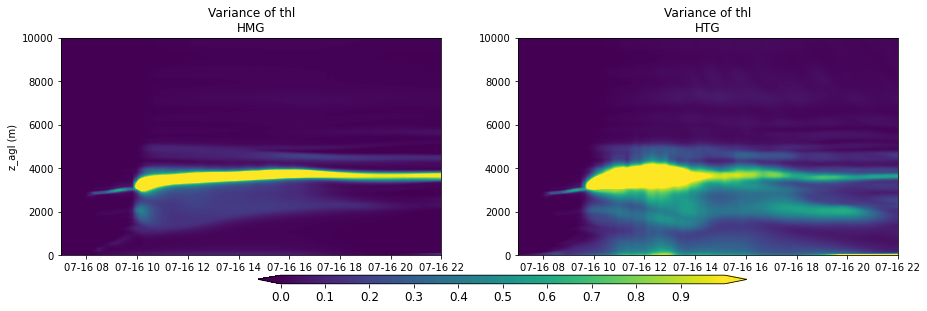

In [191]:
fig,axs=plt.subplots(1,2, figsize=(15,4))
axs = axs.ravel()

# levsc = np.arange(0.0,3.8,0.1)
levsc = np.arange(0.0,1.0,0.001)

axs[0].contourf(allTimesHMG, 
                meanZ_HMG, 
                HMGds.CSP_THL2.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_THL2.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_THL2.description+'\nHMG')
axs[1].set_title(HMGds.CSP_THL2.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])

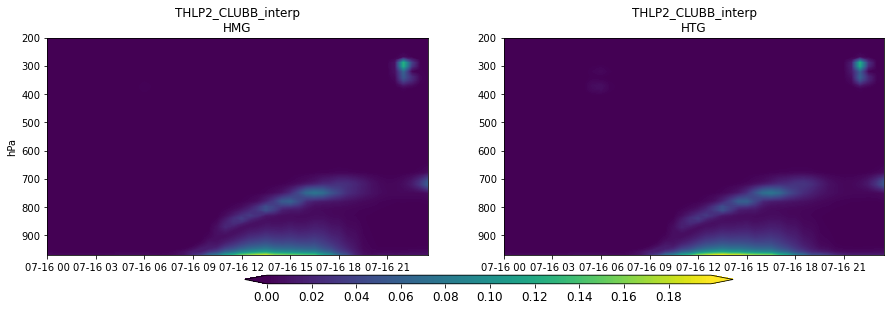

In [190]:
fig,axs=plt.subplots(1,2, figsize=(15,4))
axs = axs.ravel()

levsc = np.arange(0.0,0.2,0.001)

axs[0].contourf(hmg_day2_upsample.time.values, 
                hmg_day2_upsample.levInterp.values, 
                np.squeeze(hmg_day2_upsample.THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(htg_day2_upsample.time.values, 
                htg_day2_upsample.levInterp.values, 
                np.squeeze(htg_day2_upsample.THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 


axs[0].set_title('THLP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('THLP2_CLUBB_interp'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  
